In [ ]:
!pip install google-cloud-vision pillow

import os
import xml.etree.ElementTree as ET
from google.cloud import vision
from PIL import Image
from google.colab import drive, files
import re

# Mount Google Drive
drive.mount('/content/drive')

# Set the GOOGLE_APPLICATION_CREDENTIALS environment variable to the path in your Google Drive
credentials_path = '/content/drive/My Drive/Colab Notebooks/FYP/final-year-project-428305-b016400d8e0f.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

# Initialize Google Cloud Vision API client
client = vision.ImageAnnotatorClient()

Mounted at /content/drive


In [ ]:
# Upload input image
uploaded_input = files.upload()
input_image_path = list(uploaded_input.keys())[0]

Saving 44.jpg to 44.jpg


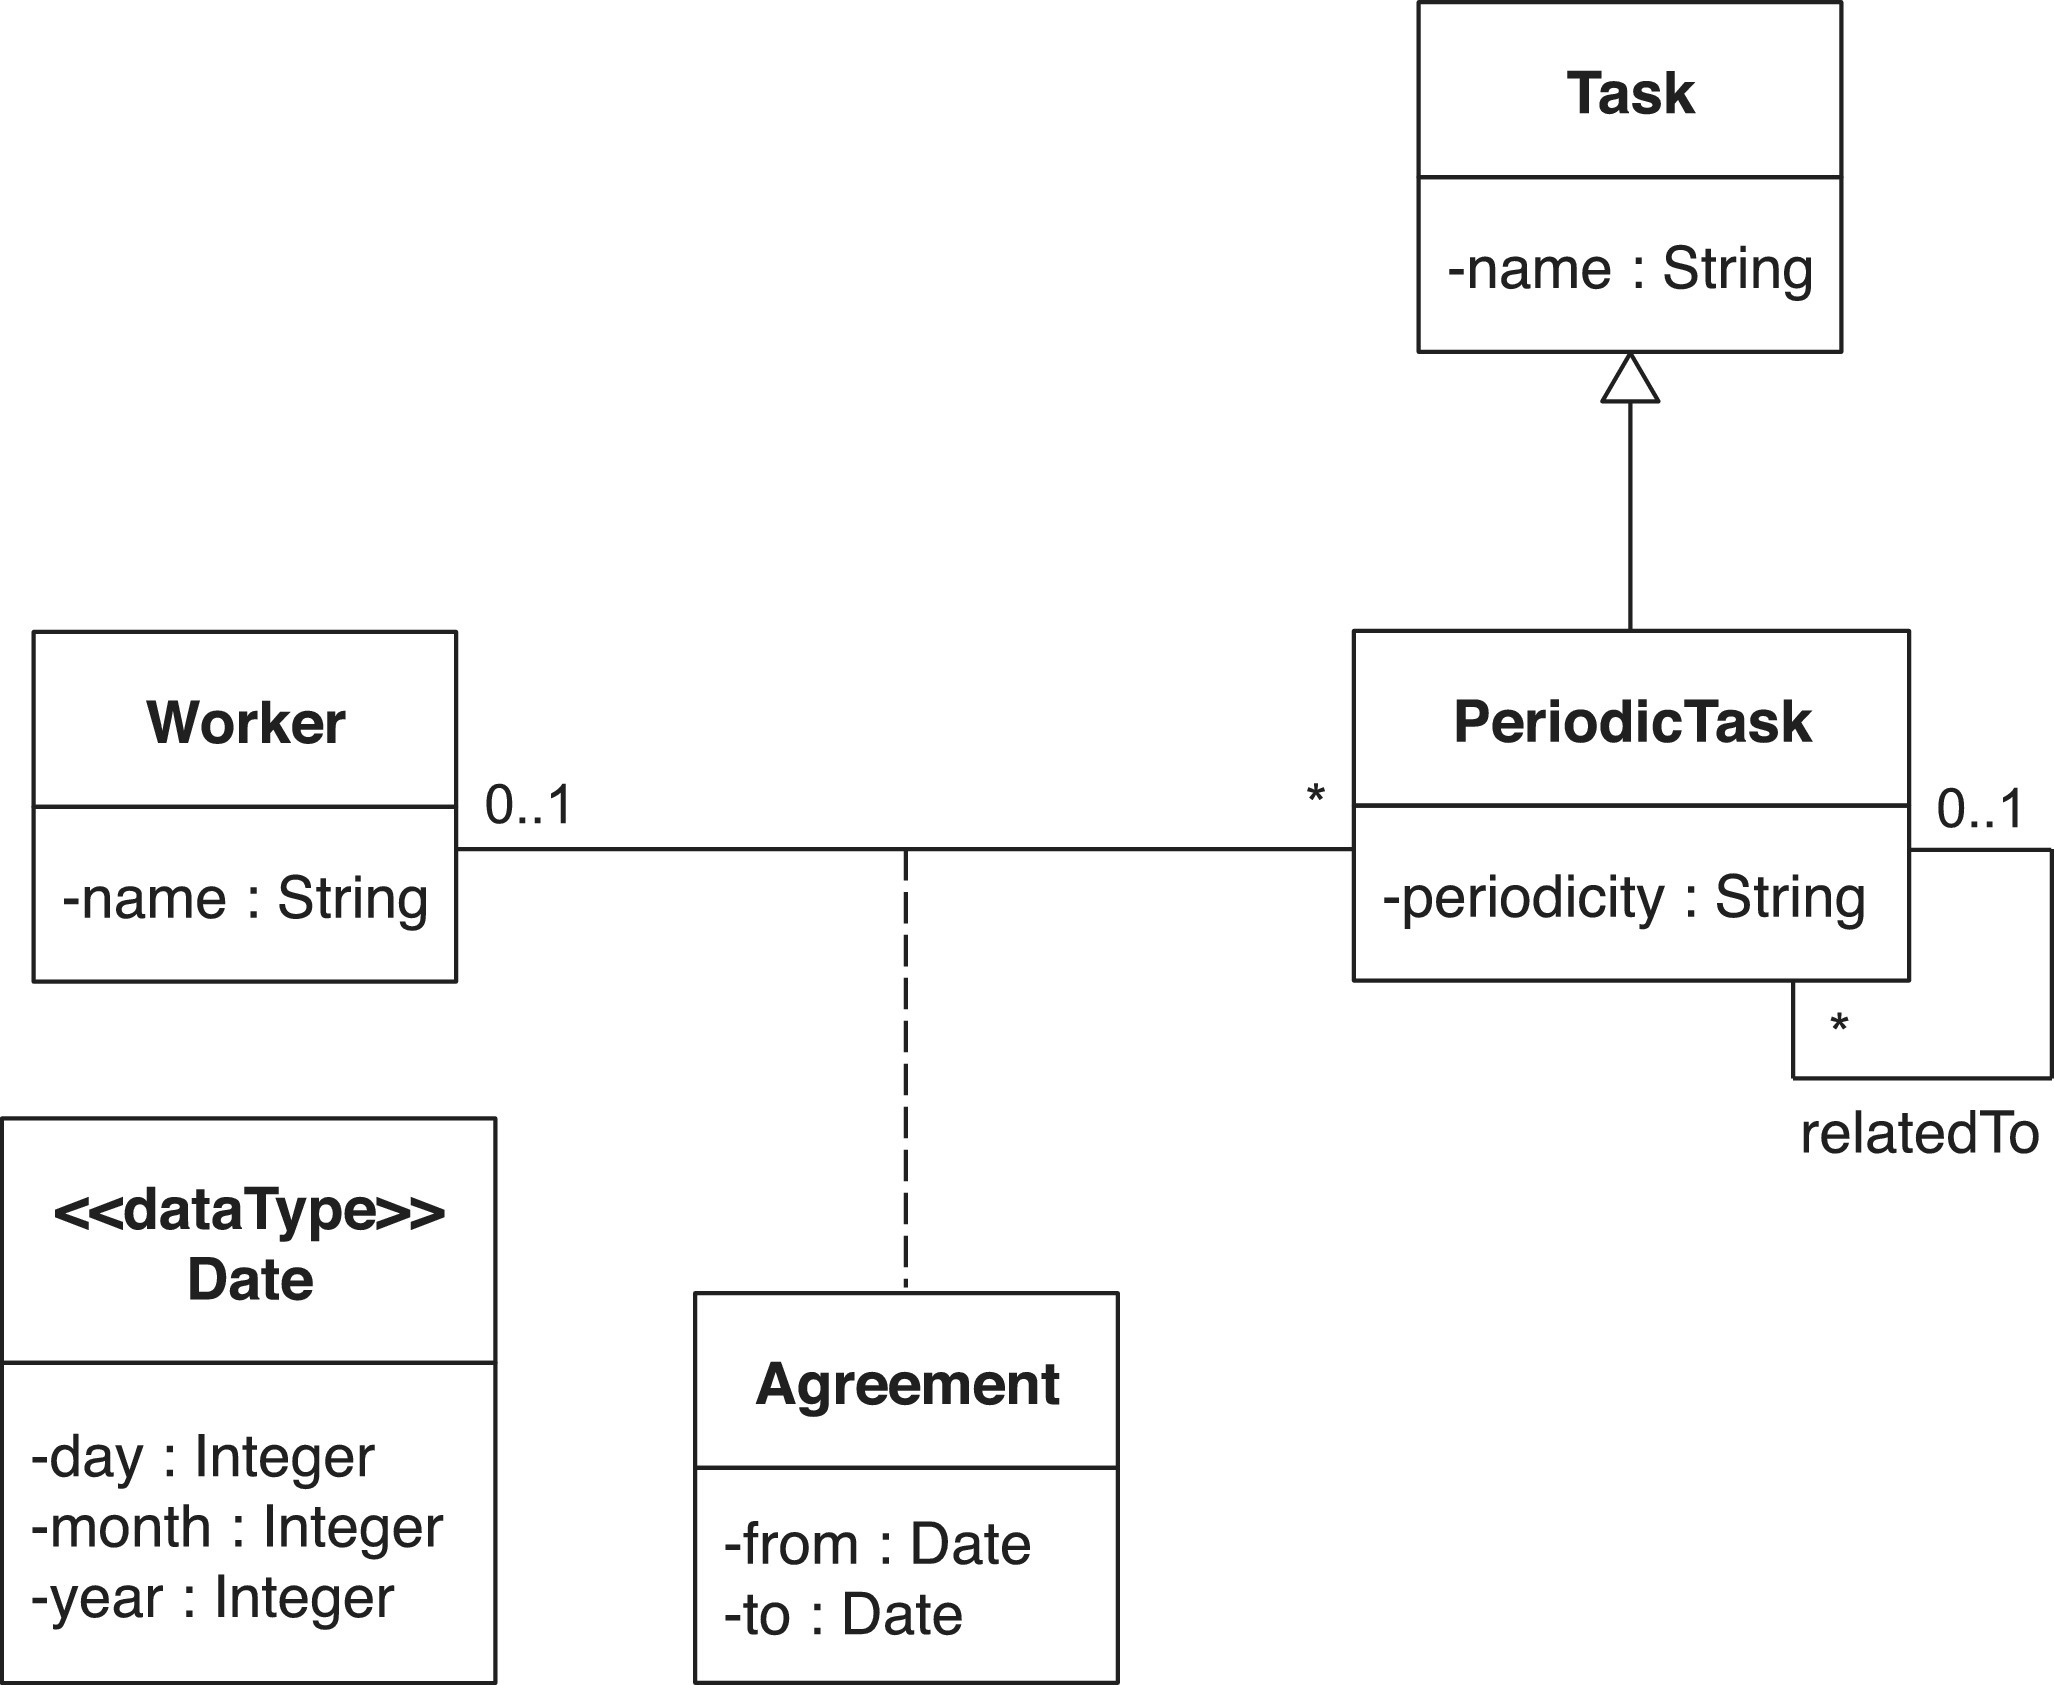

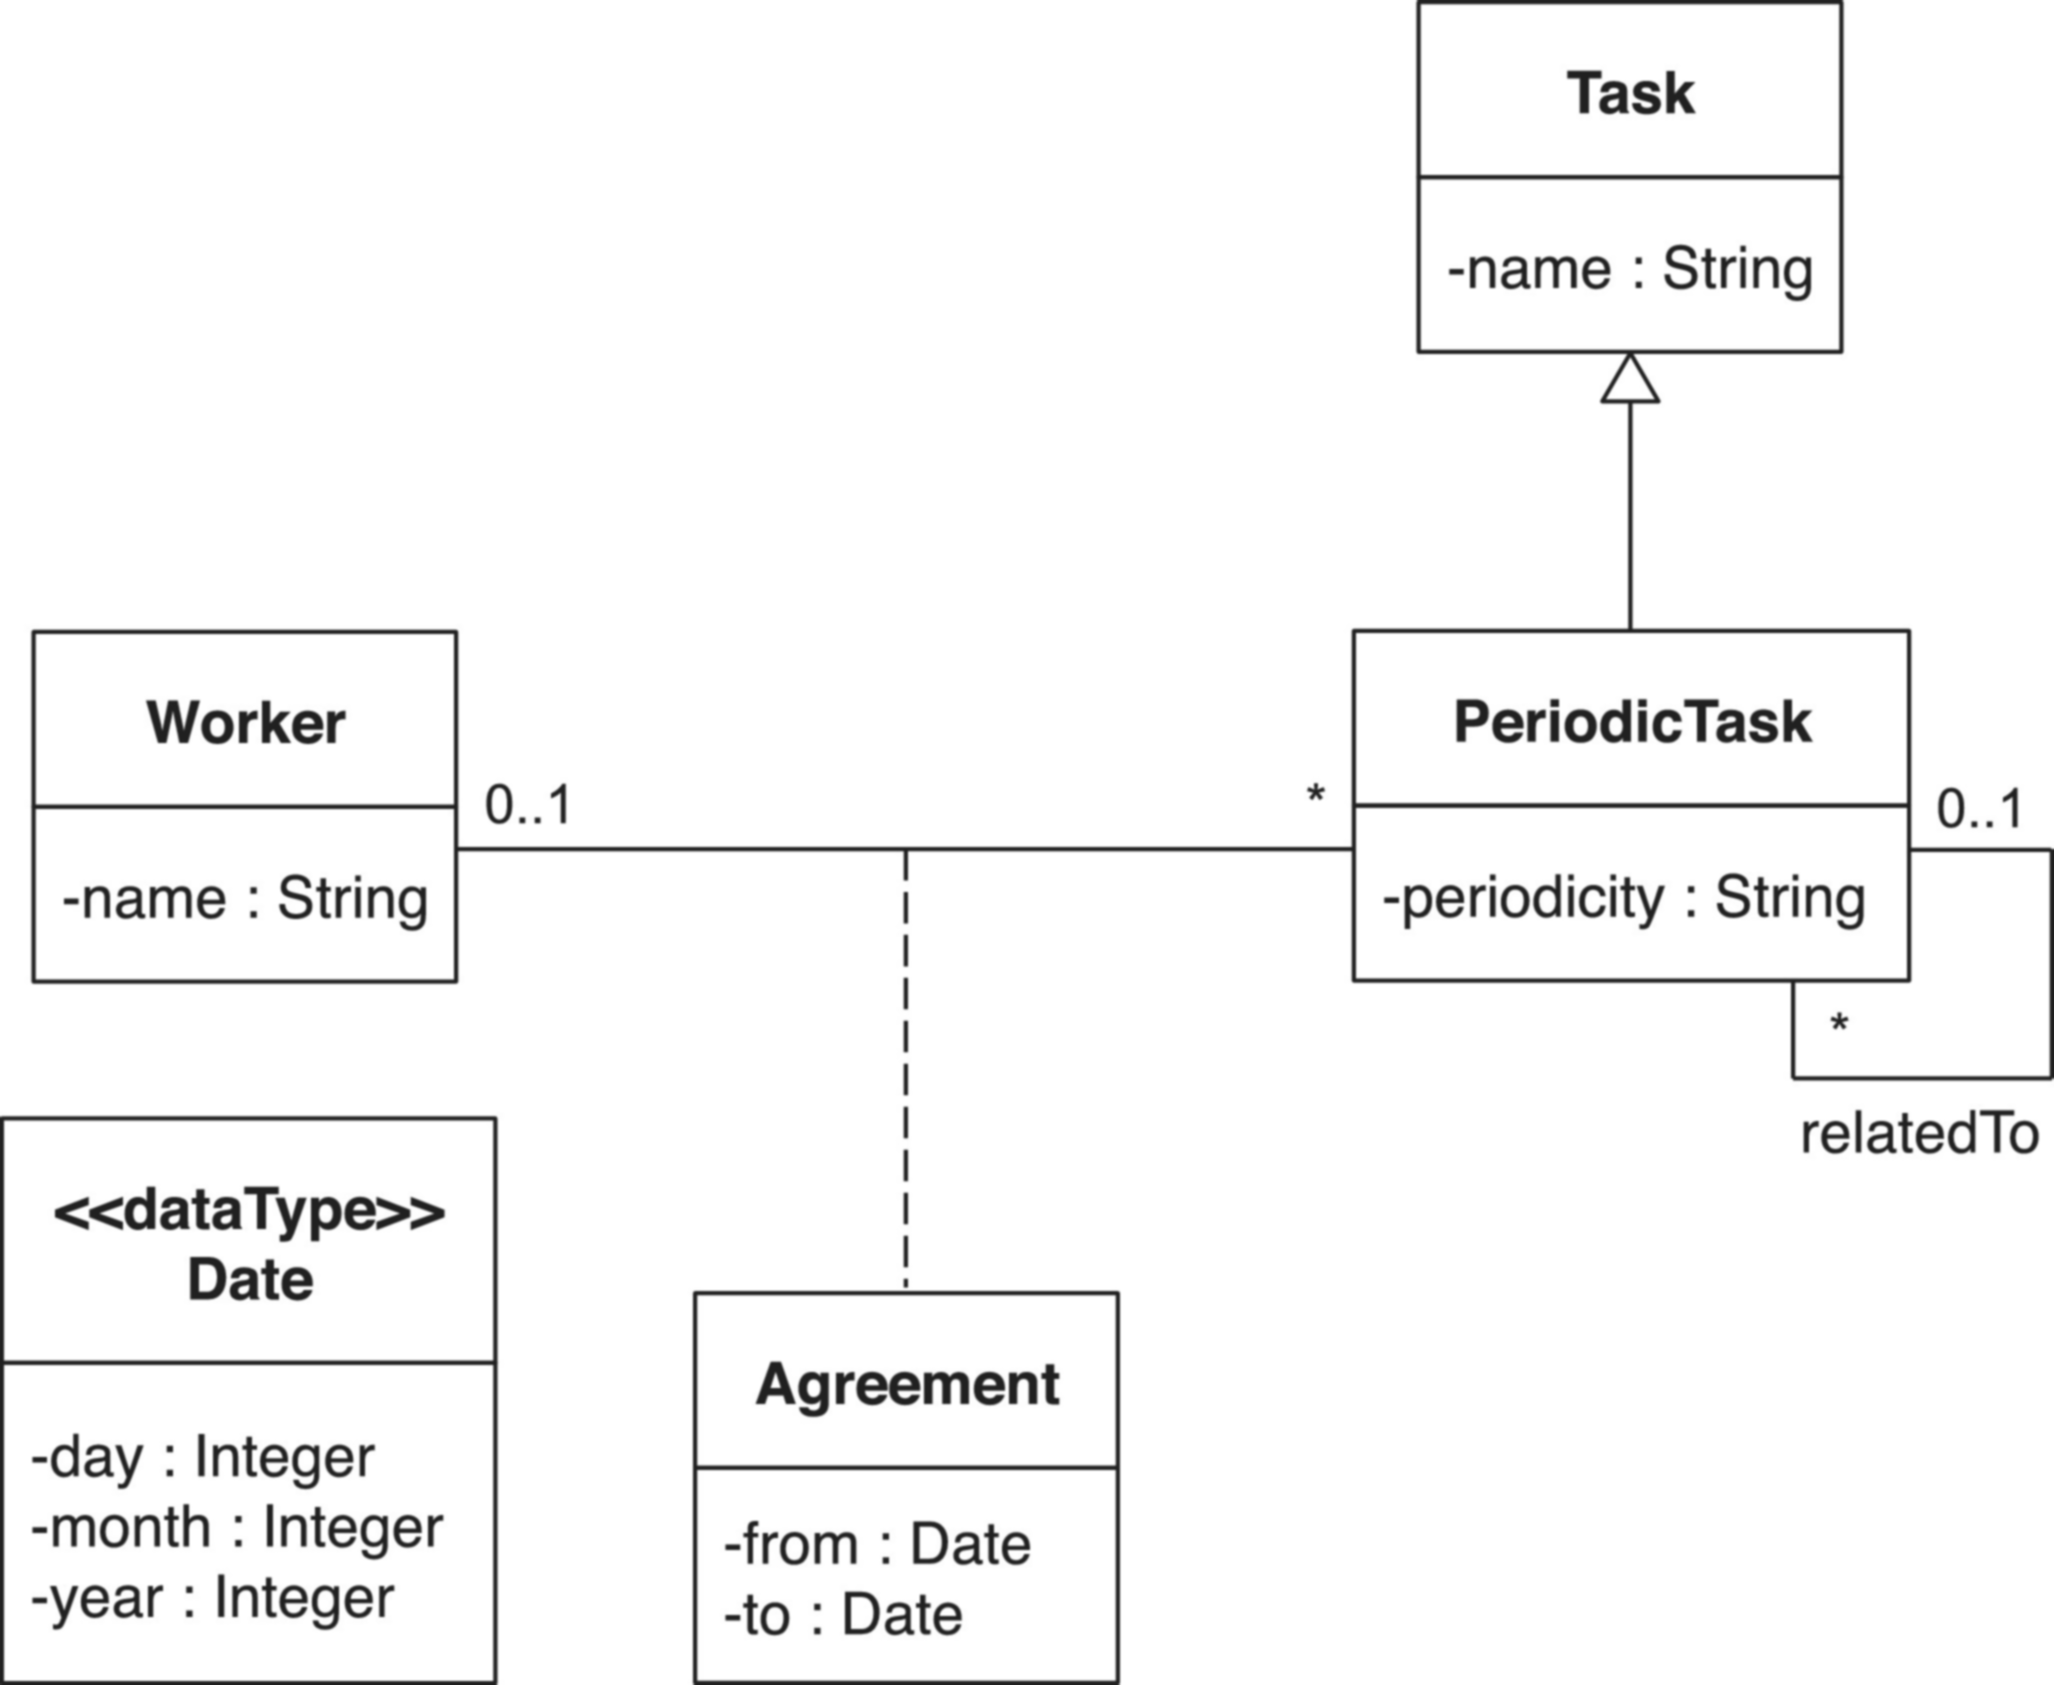

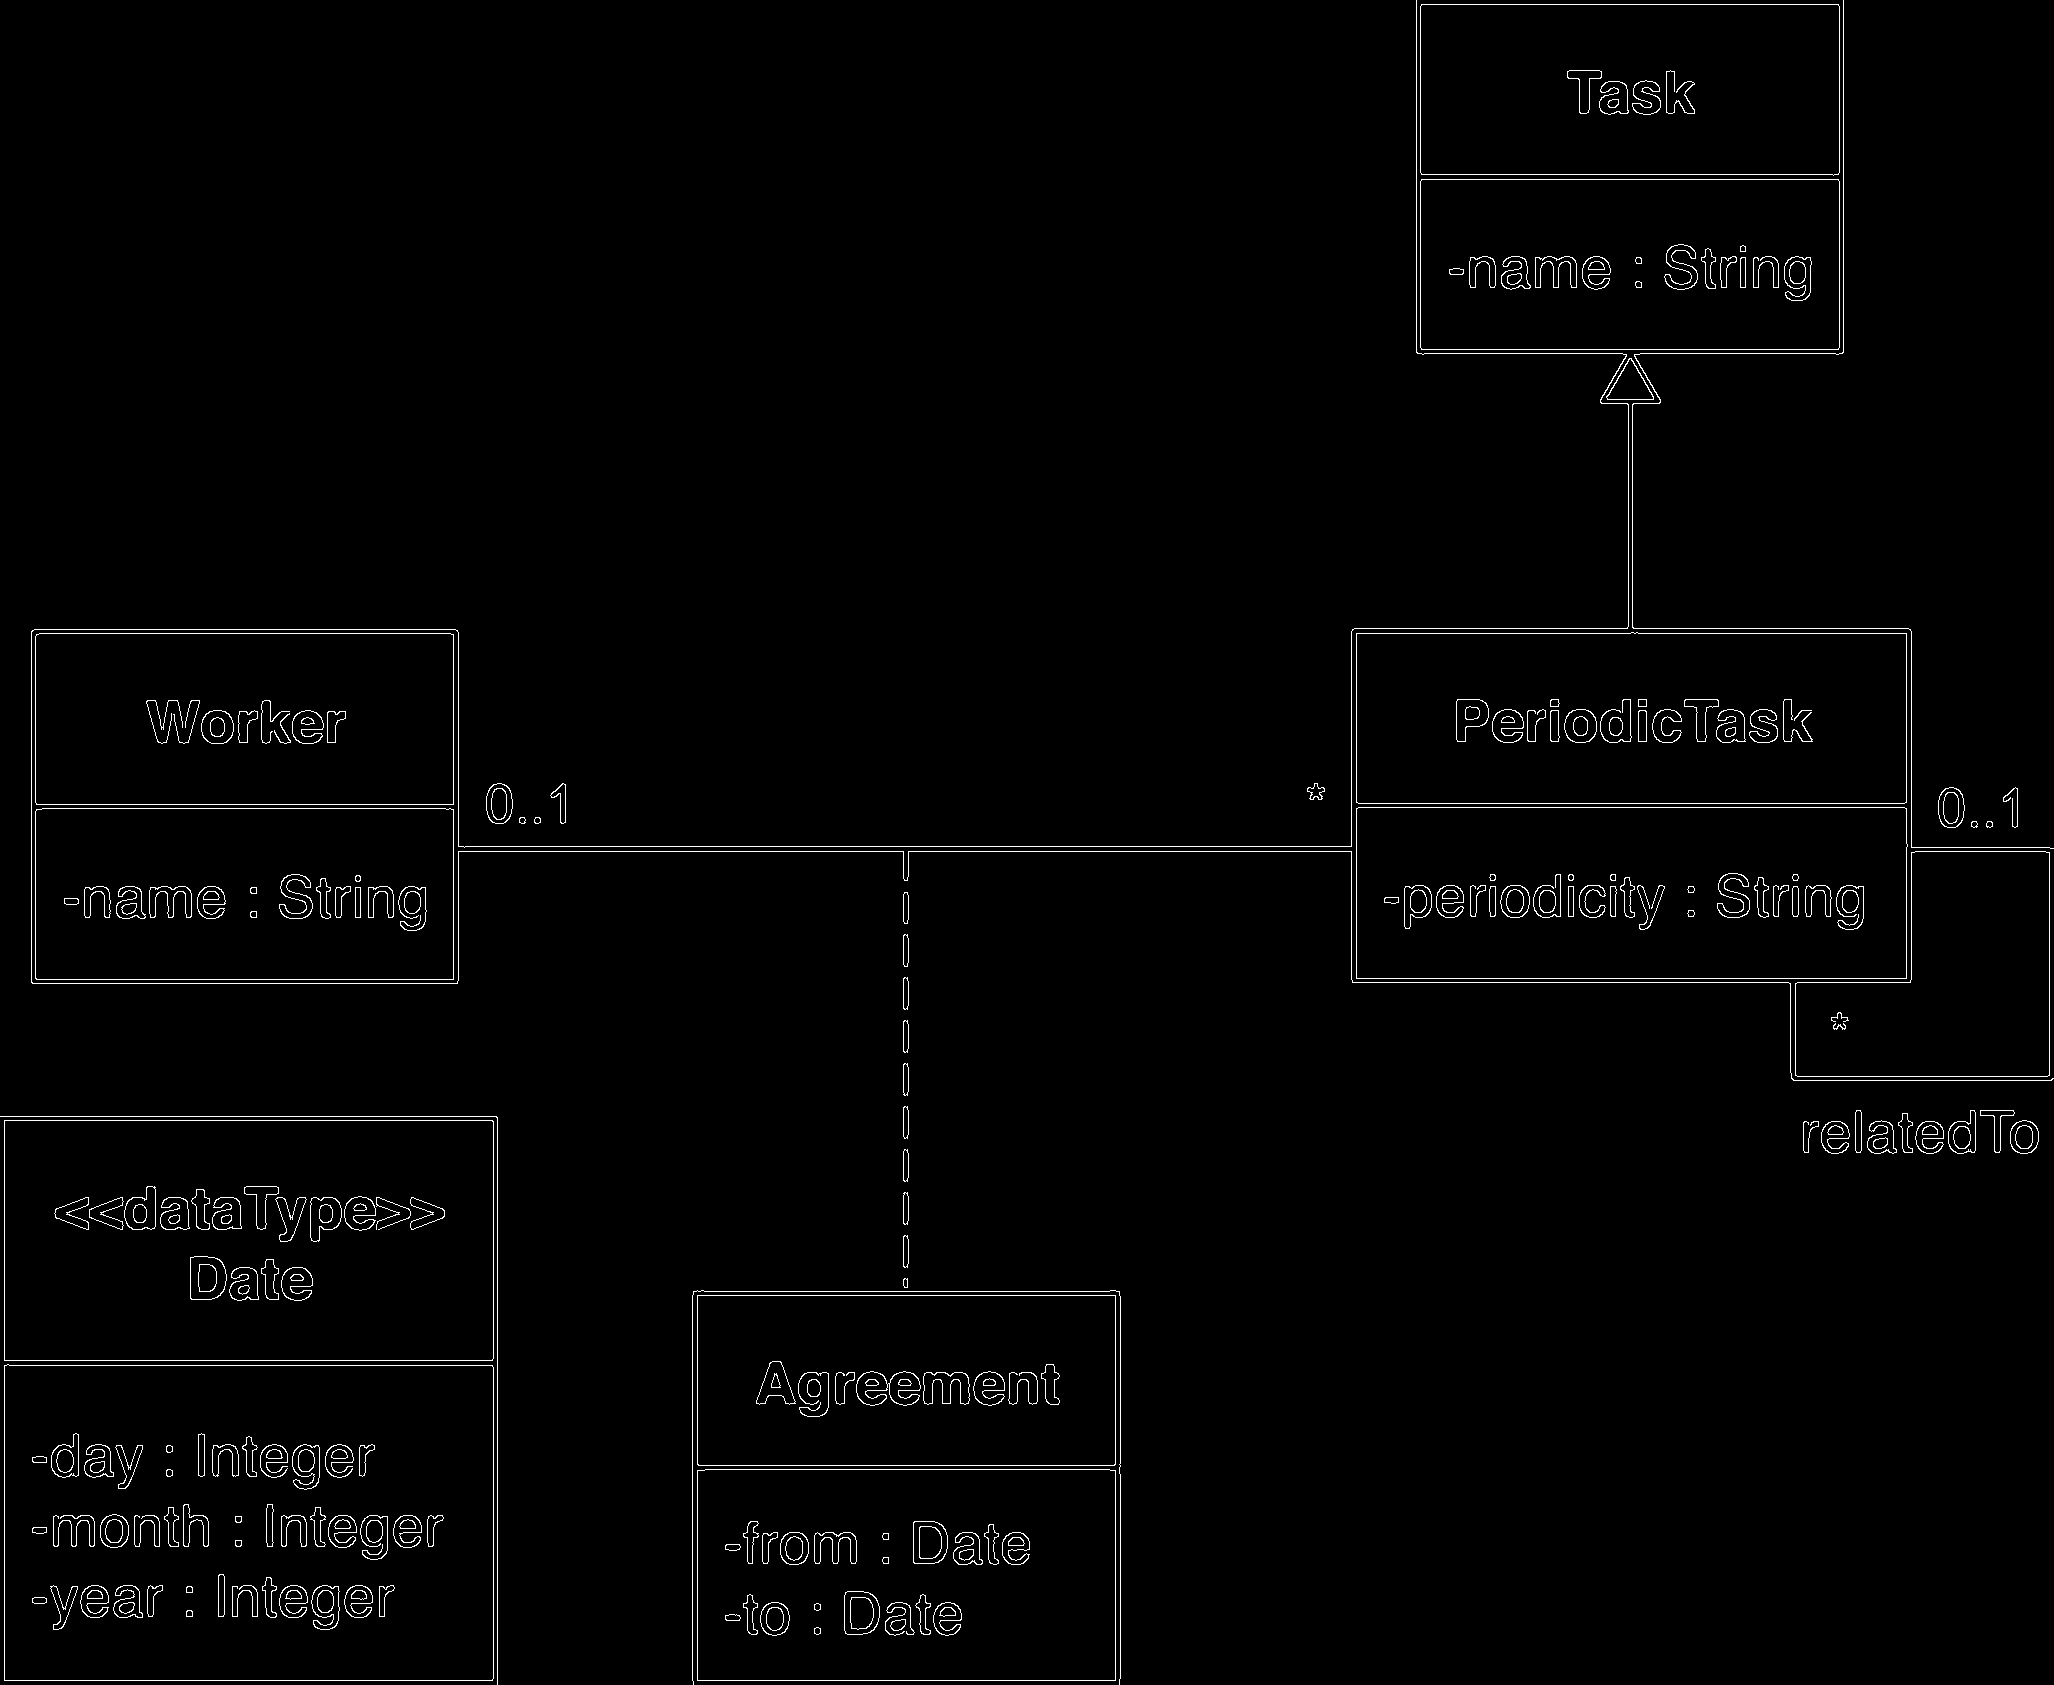

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

input_image = cv2.imread(input_image_path)

input_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

input_blurred = cv2.GaussianBlur(input_gray, (5, 5), 0)

input_edges = cv2.Canny(input_blurred, 50, 150)

cv2_imshow(input_gray)
cv2_imshow(input_blurred)
cv2_imshow(input_edges)

cv2.waitKey(0)
cv2.destroyAllWindows()


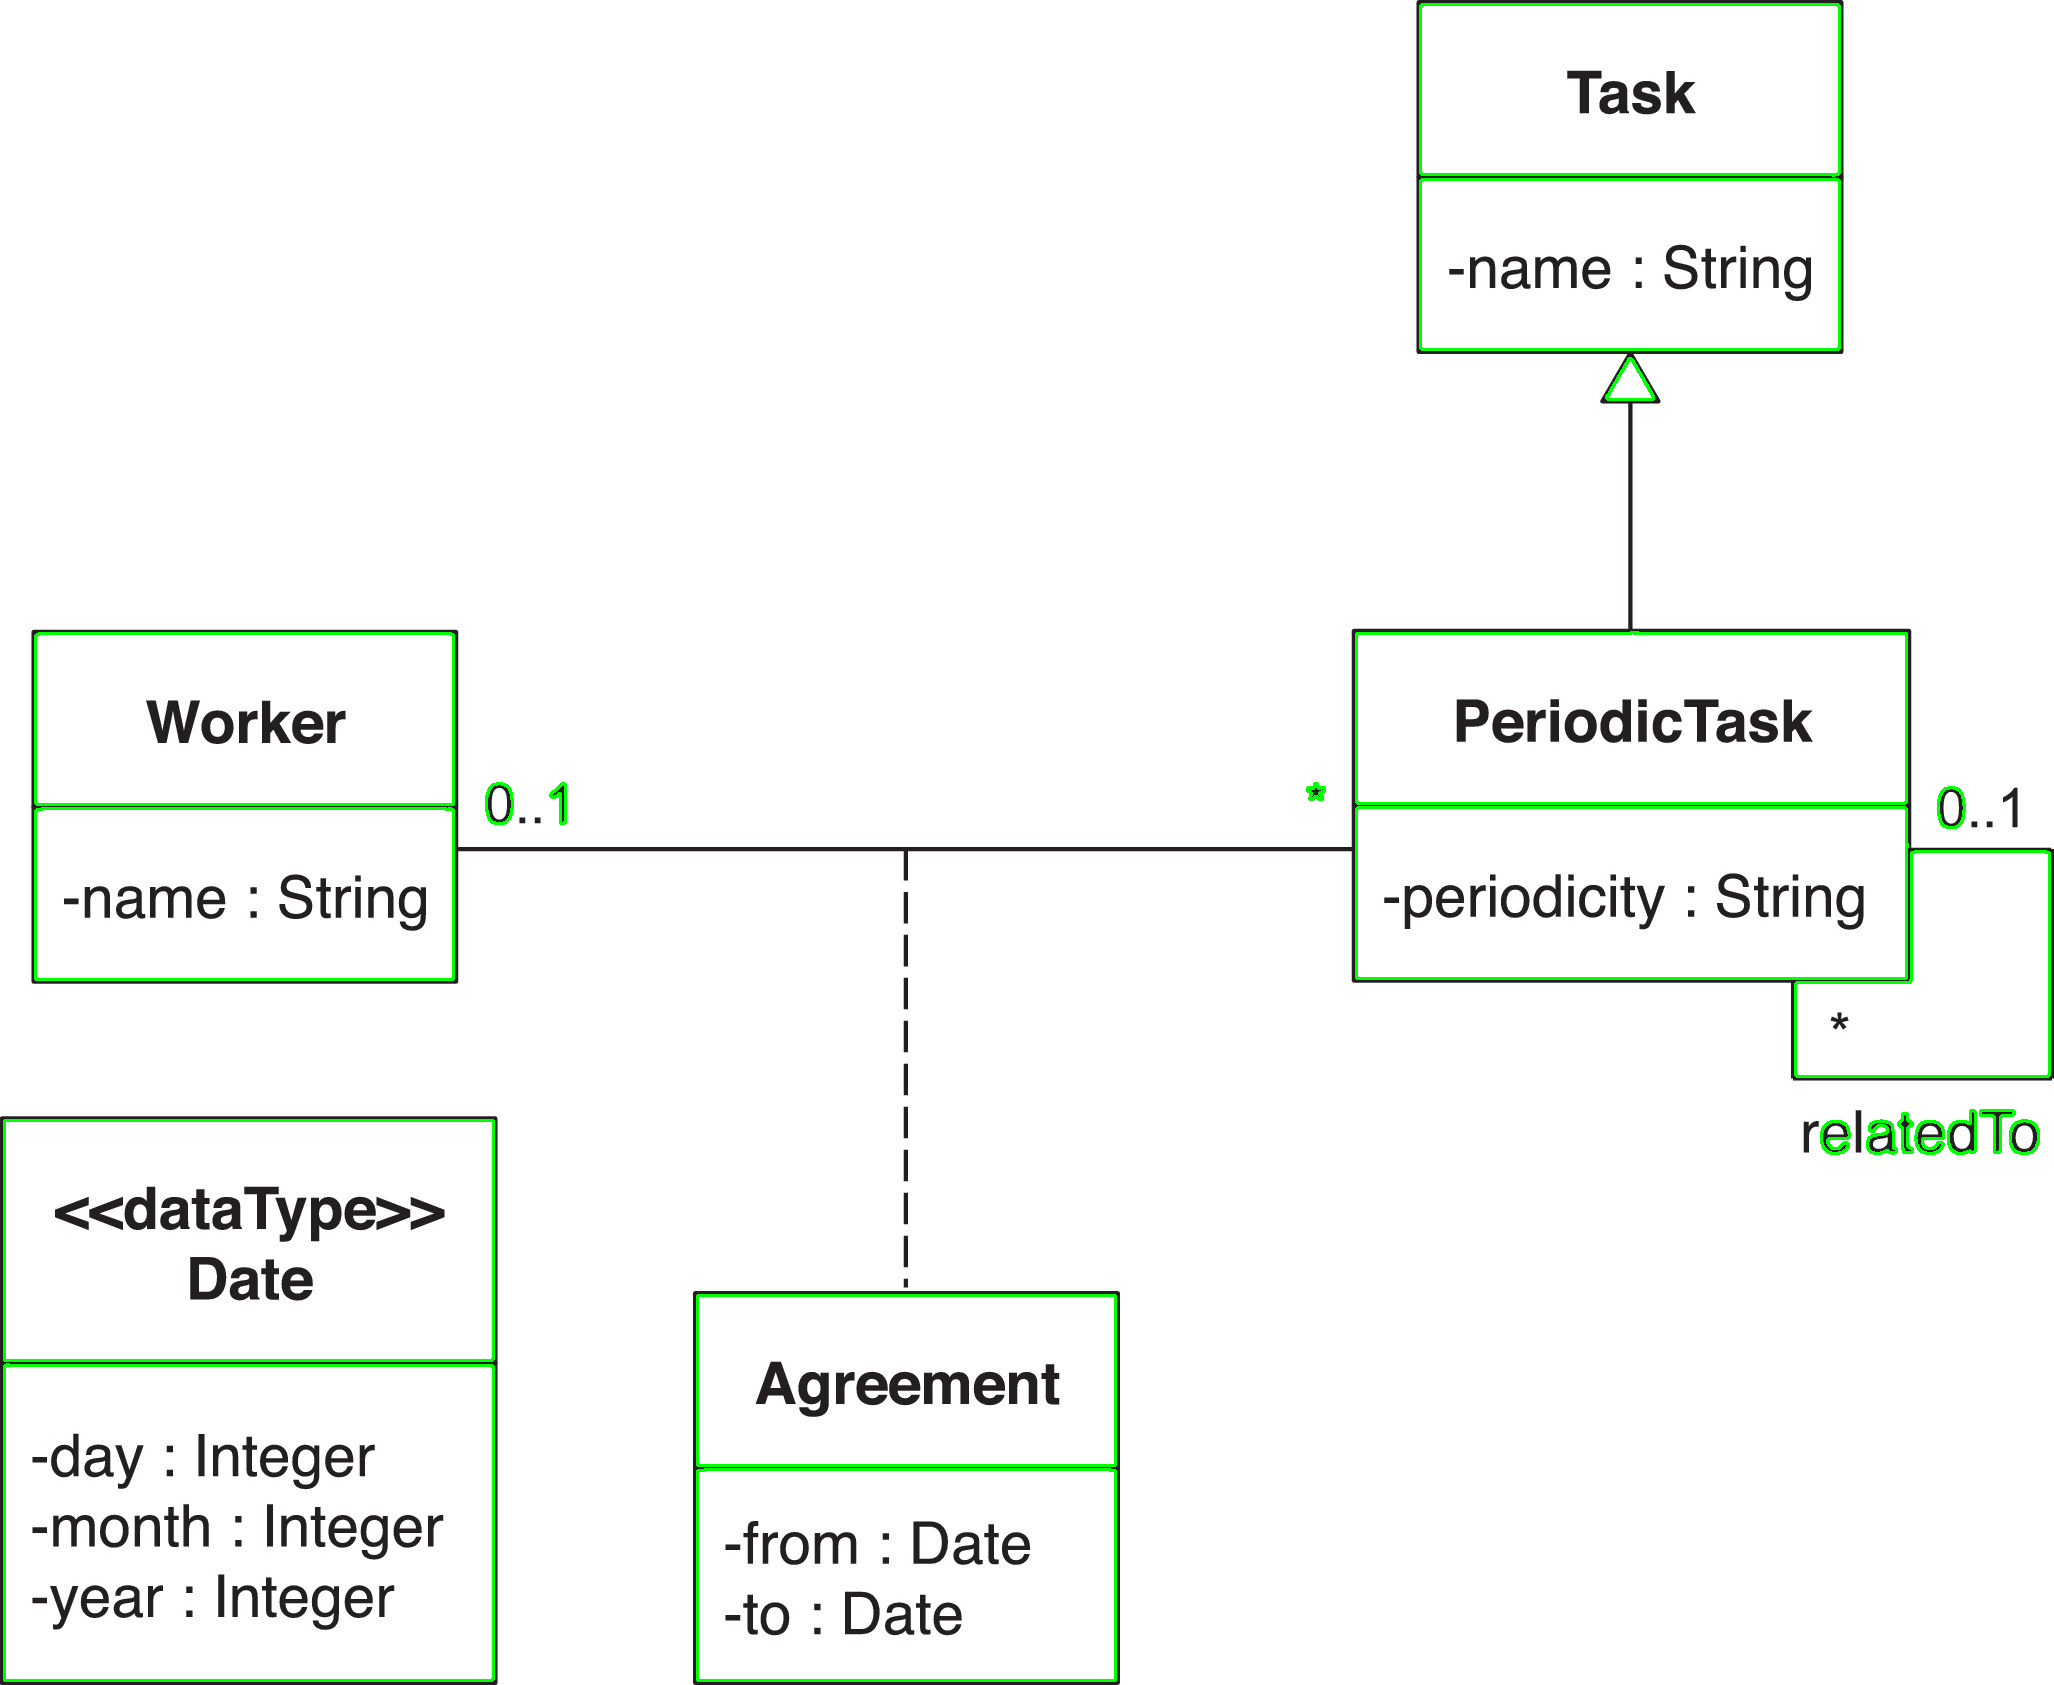

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def filter_contours(contours, min_size=100, aspect_ratio_range=(0.2, 5.0)):
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if cv2.contourArea(contour) > min_size and aspect_ratio_range[0] < (w / h) < aspect_ratio_range[1]:
            filtered_contours.append(contour)

    return filtered_contours

input_filtered_contours = filter_contours(cv2.findContours(input_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])


input_contour_image = input_image.copy()
cv2.drawContours(input_contour_image, input_filtered_contours, -1, (0, 255, 0), 2)

cv2_imshow(input_contour_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [1]:
!pip install google-cloud-vision pillow

import os
import xml.etree.ElementTree as ET
from google.cloud import vision
from PIL import Image
from google.colab import drive, files
import re

# Mount Google Drive
drive.mount('/content/drive')

# Set the GOOGLE_APPLICATION_CREDENTIALS environment variable to the path in your Google Drive
credentials_path = '/content/drive/My Drive/Colab Notebooks/FYP/final-year-project-428305-b016400d8e0f.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

# Initialize Google Cloud Vision API client
client = vision.ImageAnnotatorClient()



Mounted at /content/drive


In [14]:

def parse_xml_annotation(xml_file):
    if not os.path.exists(xml_file):
        raise FileNotFoundError(f"The file {xml_file} does not exist.")

    try:
        tree = ET.parse(xml_file)
    except ET.ParseError as e:
        raise ValueError(f"Failed to parse XML file {xml_file}: {e}")

    root = tree.getroot()
    annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        annotations.append({
            'class': class_name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return annotations

def categorize_annotations(annotations):
    classes = []
    relations = []

    for annotation in annotations:
        if annotation['class'] == 'class':
            classes.append(annotation)
        elif annotation['class'] == 'relation':
            relations.append(annotation)

    return classes, relations

def extract_text_from_image(image_path, bbox):
    image = Image.open(image_path)
    cropped_image = image.crop(bbox)

    # Save the cropped image temporarily
    temp_image_path = "/tmp/temp_image.jpg"
    cropped_image.save(temp_image_path)

    # Read the image file into memory
    with open(temp_image_path, "rb") as image_file:
        content = image_file.read()

    # Use Google Cloud Vision API to detect text
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    if texts:
        text = texts[0].description.strip()
        # Keep only English letters, numbers, and common punctuation
        text = re.sub(r'[^A-Za-z0-9\s.,-]+', '', text)
        return text
    return ""

def display_class_names_and_relations(classes, relations, image_path):
    class_names = {}
    for cls in classes:
        class_text = extract_text_from_image(image_path, cls['bbox'])
        class_lines = class_text.split('\n')
        if class_lines:
            class_name = class_lines[0]
            class_names[tuple(cls['bbox'])] = class_name
            other_text = "\n".join(class_lines[1:]) if len(class_lines) > 1 else ""
            print(f"Class Name: {class_name}")
            if other_text:
                print(f"Attributes:\n{other_text}\n")

    print("Relations:")
    for relation in relations:
        closest_classes = find_closest_classes(relation['bbox'], classes)
        if len(closest_classes) == 2:
            class_from = class_names.get(tuple(closest_classes[0]['bbox']), 'Unknown')
            class_to = class_names.get(tuple(closest_classes[1]['bbox']), 'Unknown')
            print(f"Relation: {class_from} -> {class_to}")

def find_closest_classes(relation_bbox, classes):
    closest_classes = sorted(classes, key=lambda cls: distance(relation_bbox, cls['bbox']))[:2]
    return closest_classes

def distance(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    a1, b1, a2, b2 = bbox2
    center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
    center2 = ((a1 + a2) / 2, (b1 + b2) / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

# Upload XML and Image files
uploaded = files.upload()
xml_file = list(uploaded.keys())[0]

uploaded = files.upload()
image_file = list(uploaded.keys())[0]

# Debugging: Print current working directory and check file existence
print("Current working directory:", os.getcwd())
print("Trying to access file:", xml_file)
print("File exists:", os.path.exists(xml_file))

annotations = parse_xml_annotation(xml_file)
classes, relations = categorize_annotations(annotations)

display_class_names_and_relations(classes, relations, image_file)

Saving 44.xml to 44 (2).xml


Saving 44.jpg to 44 (3).jpg
Current working directory: /content
Trying to access file: 44 (2).xml
File exists: True
Class Name: Worker
Attributes:
-name String

Class Name: dataType
Attributes:
Date
-day Integer
-month Integer
-year Integer

Class Name: Task
Attributes:
-name String

Class Name: Periodic Task
Attributes:
-periodicity String

Class Name: Agreement
Attributes:
-from Date
-to Date

Relations:
Relation: Agreement -> Worker
Relation: Periodic Task -> Task


In [15]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import re
from google.colab import files
from google.cloud import vision

# Initialize the Vision API client
client = vision.ImageAnnotatorClient()

def parse_xml_annotation(xml_file):
    if not os.path.exists(xml_file):
        raise FileNotFoundError(f"The file {xml_file} does not exist.")

    try:
        tree = ET.parse(xml_file)
    except ET.ParseError as e:
        raise ValueError(f"Failed to parse XML file {xml_file}: {e}")

    root = tree.getroot()
    annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        annotations.append({
            'class': class_name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return annotations

def categorize_annotations(annotations):
    classes = []
    relations = []

    for annotation in annotations:
        if annotation['class'] == 'class':
            classes.append(annotation)
        elif annotation['class'] in {'association', 'dependency', 'generalization', 'relation'}:
            relations.append(annotation)

    return classes, relations

def extract_text_from_image(image_path, bbox):
    image = Image.open(image_path)
    cropped_image = image.crop(bbox)

    # Save the cropped image temporarily
    temp_image_path = "/tmp/temp_image.jpg"
    cropped_image.save(temp_image_path)

    # Read the image file into memory
    with open(temp_image_path, "rb") as image_file:
        content = image_file.read()

    # Use Google Cloud Vision API to detect text
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    if texts:
        text = texts[0].description.strip()
        # Keep only English letters, numbers, and common punctuation
        text = re.sub(r'[^A-Za-z0-9\s.,-]+', '', text)
        return text
    return ""

def display_class_names_and_relations(classes, relations, image_path):
    class_names = {}
    for cls in classes:
        class_text = extract_text_from_image(image_path, cls['bbox'])
        class_lines = class_text.split('\n')
        if class_lines:
            class_name = class_lines[0]
            class_names[tuple(cls['bbox'])] = class_name
            other_text = "\n".join(class_lines[1:]) if len(class_lines) > 1 else ""
            print(f"Class Name: {class_name}")
            if other_text:
                print(f"Attributes:\n{other_text}\n")

    print("Relations:")
    for relation in relations:
        relation_text = extract_text_from_image(image_path, relation['bbox'])
        closest_classes = find_closest_classes(relation['bbox'], classes)
        if len(closest_classes) == 2:
            class_from = class_names.get(tuple(closest_classes[0]['bbox']), 'Unknown')
            class_to = class_names.get(tuple(closest_classes[1]['bbox']), 'Unknown')
            print(f"Relation: {class_from} -> {class_to} ({relation_text})")

def find_closest_classes(relation_bbox, classes):
    closest_classes = sorted(classes, key=lambda cls: distance(relation_bbox, cls['bbox']))[:2]
    return closest_classes

def distance(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    a1, b1, a2, b2 = bbox2
    center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
    center2 = ((a1 + a2) / 2, (b1 + b2) / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

# Upload XML and Image files
uploaded = files.upload()
xml_file = list(uploaded.keys())[0]

uploaded = files.upload()
image_file = list(uploaded.keys())[0]

# Debugging: Print current working directory and check file existence
print("Current working directory:", os.getcwd())
print("Trying to access file:", xml_file)
print("File exists:", os.path.exists(xml_file))

annotations = parse_xml_annotation(xml_file)
classes, relations = categorize_annotations(annotations)

display_class_names_and_relations(classes, relations, image_file)


Saving WhatsApp Image 2024-07-12 at 9.34.00 PM.xml to WhatsApp Image 2024-07-12 at 9.34.00 PM.xml


Saving WhatsApp Image 2024-07-12 at 9.34.00 PM.jpeg to WhatsApp Image 2024-07-12 at 9.34.00 PM.jpeg
Current working directory: /content
Trying to access file: WhatsApp Image 2024-07-12 at 9.34.00 PM.xml
File exists: True
Class Name: Shape
Attributes:
Area double

Class Name: Rectangle
Attributes:
Width double
height double

Class Name: Circle
Attributes:
radius double

Relations:
Relation: Shape -> Rectangle ()
Relation: Circle -> Shape ()
